## Datos de entrada y librerias

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
from scipy.optimize import minimize
from scipy.optimize import curve_fit

plt.style.use(['science','ieee'])
plt.rcParams['figure.dpi'] = 150

In [84]:
# Leer datos del excel
Triaxial_data = pd.read_excel("Triaxial_data.xlsx", skiprows=1)

# Obtener la data de triaxiales
N_samples = 4

Samples = [Triaxial_data.iloc[:, (i * 4):((i + 1) * 4)].dropna() for i in range(N_samples)]
labels_samples = ["$p'_0 = 200$kPa", "$p'_0 = 400$kPa","$p'_0 = 600$kPa", "$p'_0 = 800$kPa"]
                                                                                                                                                    
## Corrección de colnames
for i in range(N_samples - 1):
    Samples[i + 1].columns = Samples[0].columns

Samples[0]                  

,p' (kPa),q (kPa),e(axis)(%),u (kPa)
0,202.757028,0.000000,0.001887,250.419952
1,201.606402,2.083976,0.007673,251.962158
2,202.150079,3.084584,0.010566,253.607178
3,200.112661,6.390534,0.031447,255.903351
4,199.463190,9.751137,0.053837,257.548370
...,...,...,...,...
678,39.886711,38.251938,30.004353,428.013519
679,40.255850,38.283643,30.067876,428.356232
680,40.354575,38.615911,30.093159,428.253418
681,40.592748,38.471240,30.174417,427.602264


## P1. Resistencia al Corte a través de Mohr Coulomb
Los valores de los esfuerzos principales $\sigma_1$ y $\sigma_3$, se obtuvieron a través de los valores de $p'$ y $q$ según la notación Cambdrige.

$$
p' = \frac{1}{3} (\sigma'_1 + 2 \sigma'_3), \quad q = \sigma'_1 - \sigma'_3
$$
Con ello tendríamos:

$$
\sigma_3' = p' - \frac{q}{3}, \quad \sigma_1' = p' + \frac{2 q}{3}
$$

In [217]:
#Obtención de esfuerzos principales
for i in range(N_samples):
    Samples[i]["s3_eff (kPa)"] = Samples[i]["p\' (kPa)"] - Samples[i]["q (kPa)"]/3
    Samples[i]["s1_eff (kPa)"] = Samples[i]["p\' (kPa)"] + Samples[i]["q (kPa)"]*2/3
    Samples[i]["PWP Excess (kPa)"] = Samples[i]["u (kPa)"] - Samples[i]["u (kPa)"].iloc[0]
    
# Obtención de σ3 y σ1, para los circulos de Mohr
sigma = [[Samples[i]["s3_eff (kPa)"][0]-Samples[i]["PWP Excess (kPa)"].iloc[-1], 
          Samples[i]["s3_eff (kPa)"][0] + Samples[i]["q (kPa)"].iloc[-1] - Samples[i]["PWP Excess (kPa)"].iloc[-1]] for i in range(N_samples)]

sigma

[[25.78034333333335, 64.33805711426669],
 [49.72729199999998, 193.3902143333333],
 [126.09740000000005, 415.019711],
 [151.68159400000002, 550.6446970000001]]

### P1.1 Resistencia al corte en el estado crítico

Para realizar el trazo de la curva es posible obtenerlo de forma manual, pero vamos a optar en esta oportunidad, por realizar por via de automatización, tal como lo sugiere Stuyts (2023).


Ref: https://www.linkedin.com/pulse/supercharge-your-geotechnical-workflows-scipy-bruno-stuyts/

In [218]:
sigma3s = np.array([sample_sigma[0] for sample_sigma in sigma])
sigma1s = np.array([sample_sigma[1] for sample_sigma in sigma]) 
radii = 0.5 * (sigma1s - sigma3s)
centers = 0.5 * (sigma1s + sigma3s)

def objective_func(x, sigma1_effs, sigma3_effs):
    """
    Returns the squared sum of residuals for the array x
    where x[0] = tan phi and x[1] = c'
    sigma1_effs is an array with the major principal effective 
    stresses for each Mohr circle
    sigma3_effs is an array with the minor principal effective
    stresses for each Mohr circle
    """
    epsilons = np.zeros(sigma1_effs.__len__())
    for i, (sigma1, sigma3) in enumerate(zip(
        sigma1_effs, sigma3_effs)):
        epsilons[i] = (
            np.abs(x[0] * 0.5 * (sigma1 + sigma3) + x[1]) / \
            np.sqrt(x[0] ** 2 + 1) - (0.5 * (sigma1 - sigma3))) ** 2
        
    return epsilons.sum()

minimised_params = minimize(
    objective_func, # A function of one of more variables
    x0=np.array([np.tan(np.radians(10)), 10]), # Initial guess
    method='SLSQP', # Method used for the minimisation
    args=(sigma1s, sigma3s), # Function arguments
    bounds=(
        (np.tan(np.radians(5)), np.tan(np.radians(50))),
        (0, None)) # Bounds between which the parameters may vary
)

effective_friction_angle = round(
    np.rad2deg(np.arctan(minimised_params.x[0])), 1)
effective_cohesion = round(minimised_params.x[1], 1)
print(effective_friction_angle, effective_cohesion)


33.8 0.0


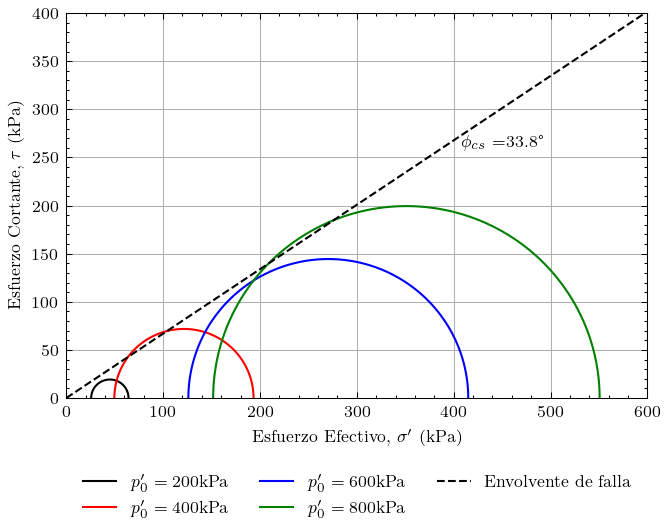

In [219]:
# Crear plot de los circulos de Mohr Coulomb
fig, ax = plt.subplots(1, 1, figsize = (5, 400/60/2))
for i in range(N_samples):
    
    # Crear los circulos
    x1, x2 = sigma[i]
    num_points = 100
    theta = np.linspace(0, np.pi, num_points)
    x = (x1 + x2) / 2 + (x2 - x1) / 2 * np.cos(theta)
    y = (x2 - x1) / 2 * np.sin(theta)

    # Plotear los resultados
    ax.plot(x, y, "-" , label = labels_samples[i])

# Añadimos un label de envolvente de falla
ax.plot([0, 600], 
        [effective_cohesion, effective_cohesion + 600 * np.tan(np.radians(effective_friction_angle))],
        "--",
        label = "Envolvente de falla",
        color = "black")

# Mostramos el ángulo de fricción obtenido para el estado critico
ax.text(450, 260, r"$\phi_{cs}=$" + str(effective_friction_angle) + "°", ha = "center") 

ax.set_xlabel("Esfuerzo Efectivo, $\sigma'$ (kPa)")
ax.set_ylabel(r"Esfuerzo Cortante, $\tau$ (kPa)")
ax.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)

ax.set_xlim(0, 600)
ax.set_ylim(0, 400)
ax.grid()
plt.savefig('critical state mohr circle.svg', format='svg')
plt.show()

En el pico, dado que se definirá en la pregunta 8, será puesto al final

## P2. Resistencia al Corte a través del espacio p-q'

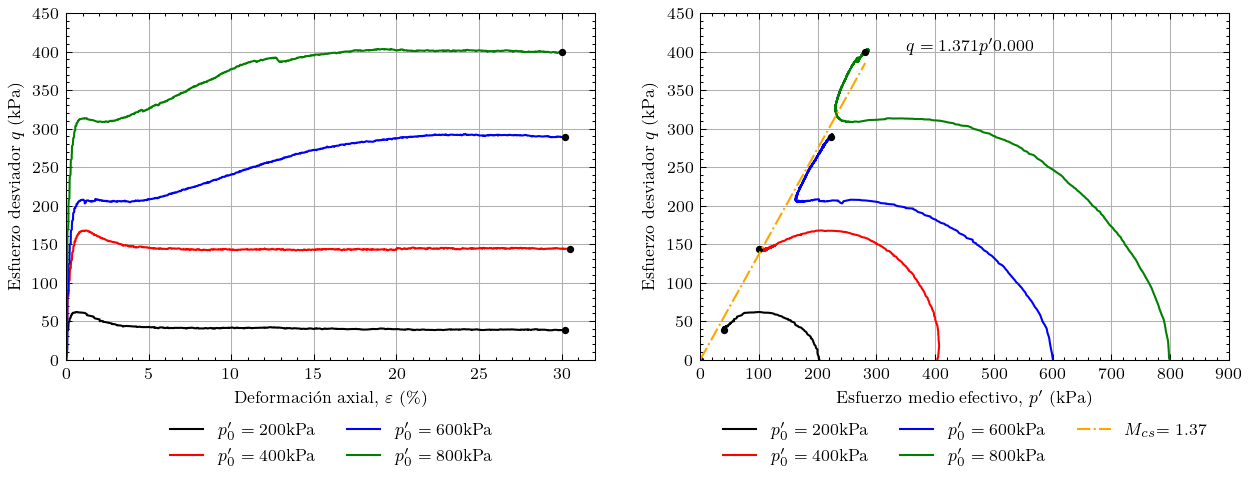

In [89]:
# Obtenemos el valor de p' y q en el estado crítico, + 0 para al regresión
critical_p = [0] + [Samples[i]["p\' (kPa)"].iloc[-1] for i in range(N_samples)]
critical_q = [0] + [Samples[i]["q (kPa)"].iloc[-1] for i in range(N_samples)]

critical_p = np.array(critical_p)
critical_q = np.array(critical_q)

max_def = np.array([Samples[i]["e(axis)(%)"].iloc[-1] for i in range(N_samples)])

# Hacemos una regresión lineal entre los resultados

coefficients = np.polyfit(critical_p, critical_q, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Regresión Linea con intercepción 0

def linear_function(x, m):
    return m * x

params, covariance = curve_fit(linear_function, critical_p , critical_q)
slope = params[0]
intercept = 0

# Cálculo del ángulo de fricción en el estado critico
M_cs = slope

phi_cs = np.arcsin((3 * M_cs)/ (6 + M_cs)) * 180 / np.pi

# Ploteamos los resultados obtenidos
fig, ax = plt.subplots(1, 2, figsize = (10, 3))



for i in range(N_samples):
    ax[0].plot(Samples[i]["e(axis)(%)"], Samples[i]["q (kPa)"], "-", label = labels_samples[i])
    ax[1].plot(Samples[i]["p\' (kPa)"], Samples[i]["q (kPa)"], "-", label = labels_samples[i])

ax[0].plot(max_def, critical_q[1:], "o", color = "black", markersize = 2.5)
ax[1].plot(critical_p, critical_q, "o", color = "black", markersize = 2.5)
ax[1].plot(critical_p, slope * critical_p + intercept, "-.", color='orange', 
        label='$M_{cs}$'+ "$ = {:.2f}$".format(round(M_cs, 2)))

ax[0].grid()
ax[0].set_xlim(0, 32)
ax[0].set_ylim(0, 450)
ax[0].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 2)
ax[0].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[0].set_ylabel("Esfuerzo desviador $q$ (kPa)")

ax[1].grid()
ax[1].set_xlim(0, 900)
ax[1].set_ylim(0, 450)
ax[1].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[1].set_xlabel("Esfuerzo medio efectivo, $p'$ (kPa)")
ax[1].set_ylabel("Esfuerzo desviador $q$ (kPa)")
ax[1].text(350, 400, "$q = {:.3f} p'$".format(round(slope,3)) + "${:.3f}$".format(round(intercept,3)))

plt.savefig('p-q diagram.svg', format='svg')

plt.show()



## P4. Linea de Estado Crítico (CSL)

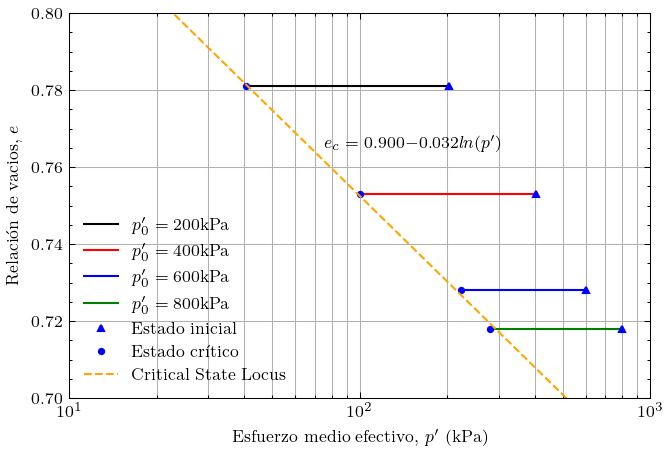

In [164]:
initial_p = np.array([Samples[i]["p\' (kPa)"][0] for i in range(N_samples)])
void_ratio = np.array([0.781, 0.753, 0.728, 0.718])

# Hacemos una regresión lineal entre los resultados
coefficients = np.polyfit(np.log(critical_p[1:]), void_ratio, 1)
slope = coefficients[0]
intercept = coefficients[1]

lambda_e = slope

# Ploteo de la linea de estado crítico
fig, ax = plt.subplots(1, 1, figsize = (5, 4*5/6))

for i in range(N_samples):
    ax.plot([initial_p[i], critical_p[i+1]], [void_ratio[i], void_ratio[i]], "-", label = labels_samples[i])

ax.plot(initial_p, void_ratio, "^", color = "blue", markersize = 2.5, label = "Estado inicial")
ax.plot(critical_p[1:], void_ratio, "o", color = "blue", markersize = 2.5, label = "Estado crítico")
ax.plot([10, 1000], [slope * np.log(10) + intercept, slope * np.log(1000) + intercept], "--", color='orange', label = "Critical State Locus")

ax.set_xlabel("Esfuerzo medio efectivo, $p'$ (kPa)")
ax.set_ylabel("Relación de vacios, $e$")
ax.set_xscale("log")

ax.text(75, 0.765, "$e_c = {:.3f}$".format(round(intercept,3)) + "${:.3f} ln(p')$".format(round(slope,3)))

ax.grid(which="both", axis='x')
ax.grid(which="major", axis='y')
ax.set_xlim(10, 1000)
ax.set_ylim(0.7, 0.8)
ax.legend(loc = "lower left")

plt.savefig('critical state graph.svg', format='svg')

plt.show()

## P5. Pendiente de la Linea de Estado Crítico

In [165]:
print("La pendiente de la linea es: " + "{:.3f}".format(-round(slope,3)))

La pendiente de la linea es: 0.032


## P6. Valor del parámetro de estado para cada ensayo $\psi$

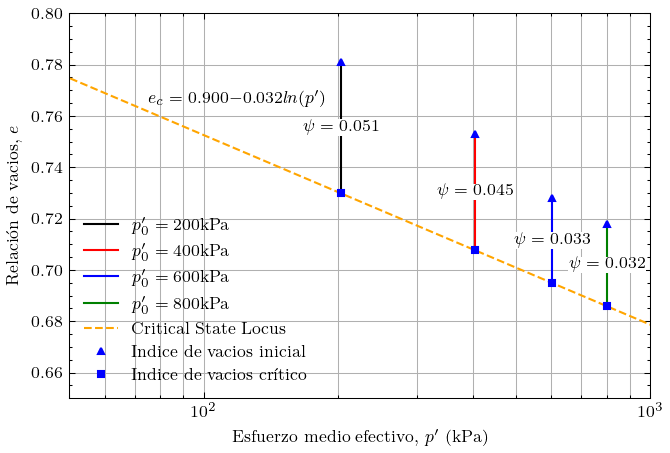

In [167]:
critical_e = [slope * np.log(initial_p[i]) + intercept for i in range(N_samples)]

# Ploteo de los parámetros de estado

fig, ax = plt.subplots(1, 1, figsize = (5, 4*5/6))

for i in range(N_samples):
    ax.plot(
        [initial_p[i], initial_p[i]], 
        [void_ratio[i], critical_e[i]], 
        "-", 
        label = labels_samples[i]
        )

ax.plot(
    [10, 1000], 
    [slope * np.log(10) + intercept, slope * np.log(1000) + intercept], 
    "--", 
    color='orange', 
    label = "Critical State Locus"
    )

ax.plot(
    initial_p, void_ratio, 
    "^", 
    color = "blue", 
    markersize = 2.5, 
    label = "Indice de vacios inicial"
    )

ax.plot(
    initial_p, 
    critical_e, 
    "s",
    color = "blue",
    markersize = 2.5, 
    label = "Indice de vacios crítico"
    )

ax.set_xlabel("Esfuerzo medio efectivo, $p'$ (kPa)")
ax.set_ylabel("Relación de vacios, $e$")
ax.set_xscale("log")

ax.text(75, 
        0.765, 
        "$e_c = {:.3f}$".format(round(intercept,3)) + 
        "${:.3f} ln(p')$".format(round(slope,3))
        )

# Cálculo de psi
psi = [void_ratio[i] - critical_e[i] for i in range(N_samples)]

# Ploteamos psi en la gráfica
for i in range(N_samples):
        
    text = ax.text(
        initial_p[i], 
        (void_ratio[i] + critical_e[i]) * 0.5, 
        "$\psi = {:.3f}$".format(psi[i]), 
        ha='center', 
        va='center'
        )
    
    text.set_bbox(
        dict(
            facecolor="white", 
            edgecolor='none', 
            pad=0.5
            )
        )

ax.grid(which="both", axis='x')
ax.grid(which="major", axis='y')
ax.set_xlim(50, 1000)
ax.set_ylim(0.65, 0.8)
ax.legend(loc = "lower left")
plt.savefig('critical state psi graph.svg', format='svg')

plt.show()

## P7. Definición del estado de cada muestra

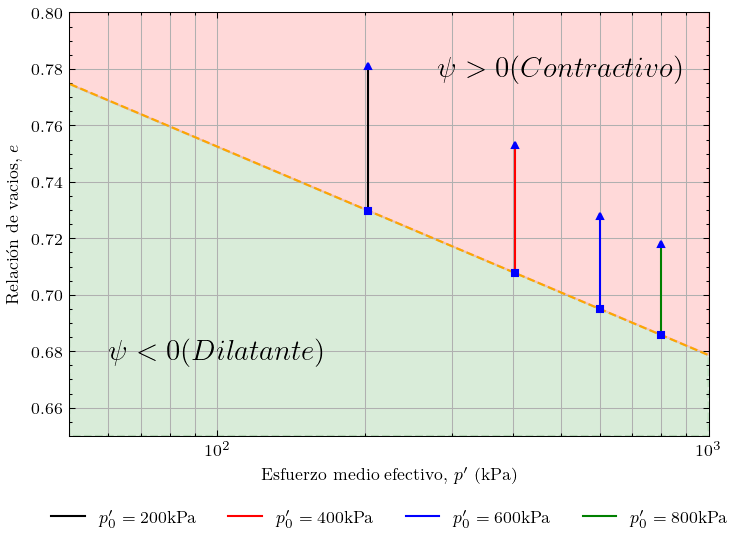

In [93]:
# Ploteo de los parámetros de estado

fig, ax = plt.subplots(1, 1, figsize = (5.5, 4*5.5/6))

for i in range(N_samples):
    ax.plot(
        [initial_p[i], initial_p[i]], 
        [void_ratio[i], critical_e[i]], 
        "-", 
        label = labels_samples[i]
        )

ax.plot(
    [10, 1000], 
    [slope * np.log(10) + intercept, slope * np.log(1000) + intercept], 
    "--", 
    color='orange'
    )

ax.plot(
    initial_p, void_ratio, 
    "^", 
    color = "blue", 
    markersize = 2.5
    )

ax.plot(
    initial_p, 
    critical_e, 
    "s",
    color = "blue",
    markersize = 2.5
    )

ax.set_xlabel("Esfuerzo medio efectivo, $p'$ (kPa)")
ax.set_ylabel("Relación de vacios, $e$")
ax.set_xscale("log")

# for i in range(N_samples):
    
#     text = ax.text(
#         initial_p[i], 
#         (void_ratio[i] + critical_e[i]) * 0.5, 
#         "$\psi = {:.3f}$".format(void_ratio[i] - critical_e[i]), 
#         ha='center', 
#         va='center'
#         )
    
#     text.set_bbox(
#         dict(
#             facecolor="white", 
#             edgecolor='none', 
#             pad=0.5
#             )
#         )

ax.fill(
    [50, 50, 1000, 1000],
    [slope * np.log(50) + intercept, 0.8, 0.8, slope * np.log(1000) + intercept],
    color = "red",
    alpha = 0.15
)

ax.fill(
    [50, 50, 1000, 1000],
    [0.65,  slope * np.log(50) + intercept, slope * np.log(1000) + intercept, 0.65],
    color = "green",
    alpha = 0.15
)

ax.text(
    100,
    0.68,
    "$\psi < 0 (Dilatante)$",
    fontsize = 14,
    ha='center', 
    va='center'
)

ax.text(
    500,
    0.78,
    "$\psi > 0 (Contractivo)$",
    fontsize = 14,
    ha='center', 
    va='center'
)

ax.grid(which="both", axis='x')
ax.grid(which="major", axis='y')
ax.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol = 4)
ax.set_xlim(50, 1000)
ax.set_ylim(0.65, 0.8)
plt.savefig('critical state behaviour graph.svg', format='svg')
plt.show()

## P8. Exceso de presión de poros en el estado critico (residual)

Text(0, 0.5, 'Exceso de Presión de Poros, $u$ (kPa)')

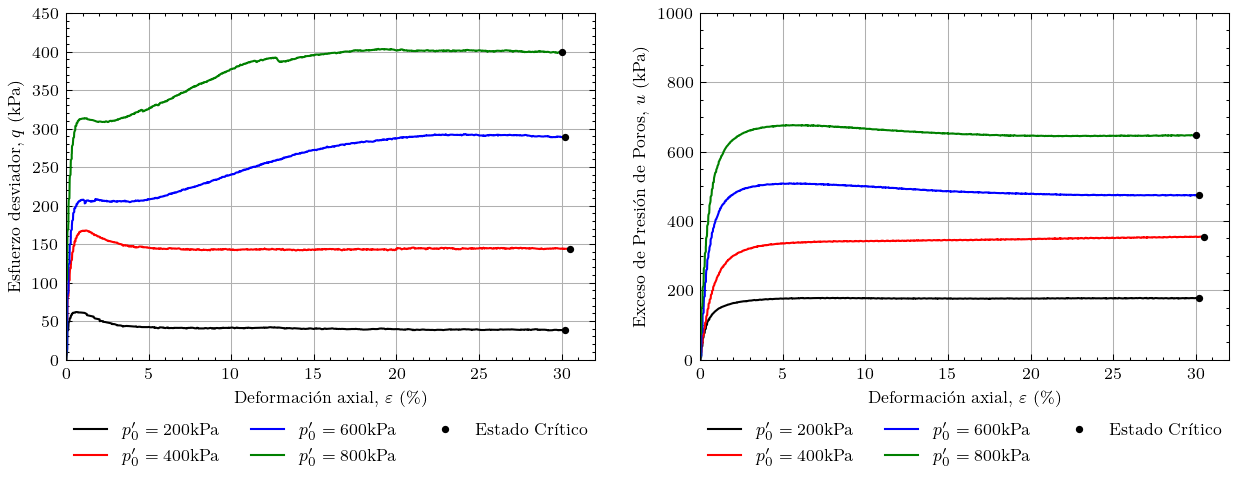

In [94]:
# Ploteamos los resultados obtenidos
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

for i in range(N_samples):
    
    ax[0].plot(
        Samples[i]["e(axis)(%)"], 
        Samples[i]["q (kPa)"], 
        "-", 
        label = labels_samples[i]
        )
    
    ax[1].plot(
        Samples[i]["e(axis)(%)"],
        Samples[i]["PWP Excess (kPa)"],
        "-", 
        label = labels_samples[i]
        )

# Obtenemos la localización del estado crítico
ax[0].plot(
    max_def, critical_q[1:], 
    "o", 
    color = "black", 
    markersize = 2.5,
    label = "Estado Crítico"
    )

# Calculamos el exceso de presión de poros asociado
excess_pp = np.array(
    [Samples[i]["PWP Excess (kPa)"].iloc[-1] for i in range(N_samples)]
)

ax[1].plot(
    max_def, 
    excess_pp,
    "o",
    color = "black",
    markersize = 2.5,
    label = "Estado Crítico"
)

ax[0].grid()
ax[0].set_xlim(0, 32)
ax[0].set_ylim(0, 450)
ax[0].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[0].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[0].set_ylabel("Esfuerzo desviador, $q$ (kPa)")

ax[1].grid()
ax[1].set_xlim(0, 32)
ax[1].set_ylim(0, 1000)
ax[1].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[1].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[1].set_ylabel("Exceso de Presión de Poros, $u$ (kPa)")



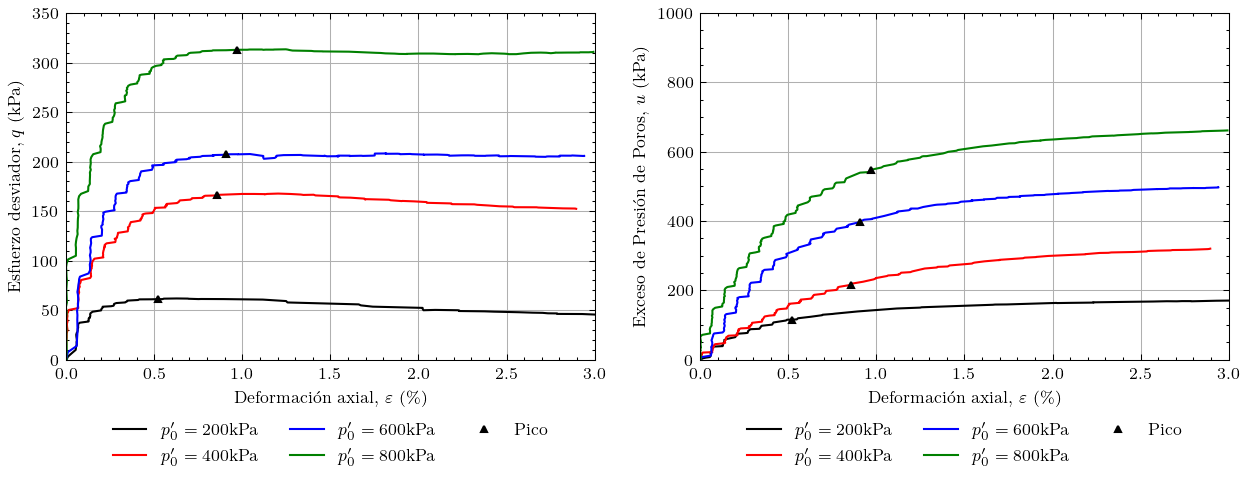

In [136]:
# El pico lo encontramos aproximadamente cuando es menor a 3%
Samples_3percent = [Samples[i].loc[Samples[i]["e(axis)(%)"] < 3] for i in range(N_samples)]

# Ploteamos los resultados obtenidos
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

for i in range(N_samples):
    
    ax[0].plot(
        Samples_3percent[i]["e(axis)(%)"], 
        Samples_3percent[i]["q (kPa)"], 
        "-", 
        label = labels_samples[i]
        )
    
    ax[1].plot(
        Samples_3percent[i]["e(axis)(%)"],
        Samples_3percent[i]["PWP Excess (kPa)"],
        "-", 
        label = labels_samples[i]
        )

# peak_dataframe = [Samples_3percent[i].loc[Samples_3percent[i]["q (kPa)"].idxmax()] for i in range(N_samples)]

peak_dataframe = [
    Samples_3percent[0].iloc[54],
    Samples_3percent[1].iloc[130],
    Samples_3percent[2].iloc[105],
    Samples_3percent[3].iloc[160],
]

peak_def = np.array(
    [peak_dataframe[i]["e(axis)(%)"] for i in range(N_samples)]
    )

peak_q = np.array(
    [peak_dataframe[i]["q (kPa)"] for i in range(N_samples)]
    )

peak_p = np.array(
    [peak_dataframe[i]["p\' (kPa)"] for i in range(N_samples)]
    )

peak_pp = np.array(
    [peak_dataframe[i]["PWP Excess (kPa)"] for i in range(N_samples)]
    )

# Ploteamos el pico
ax[0].plot(
    peak_def,
    peak_q, 
    "^", 
    color = "black", 
    markersize = 2.5,
    label = "Pico"
    )

ax[1].plot(
    peak_def,
    peak_pp, 
    "^",
    color = "black",
    markersize = 2.5,
    label = "Pico"
)

ax[0].grid()
ax[0].set_xlim(0, 3)
ax[0].set_ylim(0, 350)
ax[0].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[0].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[0].set_ylabel("Esfuerzo desviador, $q$ (kPa)")

ax[1].grid()
ax[1].set_xlim(0, 3)
ax[1].set_ylim(0, 1000)
ax[1].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[1].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[1].set_ylabel("Exceso de Presión de Poros, $u$ (kPa)")

plt.savefig('peak q and excess_pp.svg', format='svg')
plt.show()


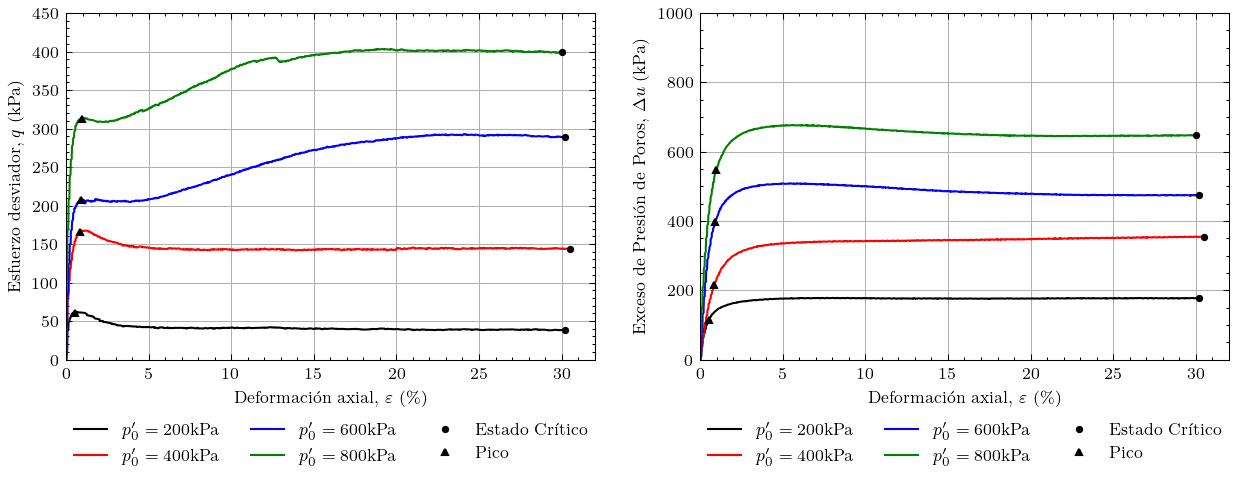

In [144]:
# Ploteamos los resultados obtenidos
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

for i in range(N_samples):
    
    ax[0].plot(
        Samples[i]["e(axis)(%)"], 
        Samples[i]["q (kPa)"], 
        "-", 
        label = labels_samples[i]
        )
    
    ax[1].plot(
        Samples[i]["e(axis)(%)"],
        Samples[i]["PWP Excess (kPa)"],
        "-", 
        label = labels_samples[i]
        )

# Obtenemos la localización del estado crítico
ax[0].plot(
    max_def, critical_q[1:], 
    "o", 
    color = "black", 
    markersize = 2.5,
    label = "Estado Crítico"
    )

# Calculamos el exceso de presión de poros asociado
excess_pp = np.array(
    [Samples[i]["PWP Excess (kPa)"].iloc[-1] for i in range(N_samples)]
)

ax[1].plot(
    max_def, 
    excess_pp,
    "o",
    color = "black",
    markersize = 2.5,
    label = "Estado Crítico"
)

# Ploteamos el pico
ax[0].plot(
    peak_def,
    peak_q, 
    "^", 
    color = "black", 
    markersize = 2.5,
    label = "Pico"
    )

ax[1].plot(
    peak_def,
    peak_pp, 
    "^",
    color = "black",
    markersize = 2.5,
    label = "Pico"
)

ax[0].grid()
ax[0].set_xlim(0, 32)
ax[0].set_ylim(0, 450)
ax[0].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[0].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[0].set_ylabel("Esfuerzo desviador, $q$ (kPa)")

ax[1].grid()
ax[1].set_xlim(0, 32)
ax[1].set_ylim(0, 1000)
ax[1].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[1].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[1].set_ylabel("Exceso de Presión de Poros, $\Delta u$ (kPa)")
plt.savefig('q and excess_pp.svg', format='svg')
plt.show()

In [139]:
peak_dataframe[3]

p' (kPa)            355.617808
q (kPa)             312.722000
e(axis)(%)            0.969673
u (kPa)             798.965424
s3_eff (kPa)        251.377141
s1_eff (kPa)        564.099141
PWP Excess (kPa)    546.797638
Ru                   68.403251
Name: 160, dtype: float64

In [142]:
[excess_pp[i] * 100 / Samples[i]["p\' (kPa)"].iloc[0] for i in range(N_samples)]

[87.28510496269931, 87.6898880310705, 79.00296145939919, 81.0249471497853]

## P9. Valores de q y p' en el pico y en el estado crítico

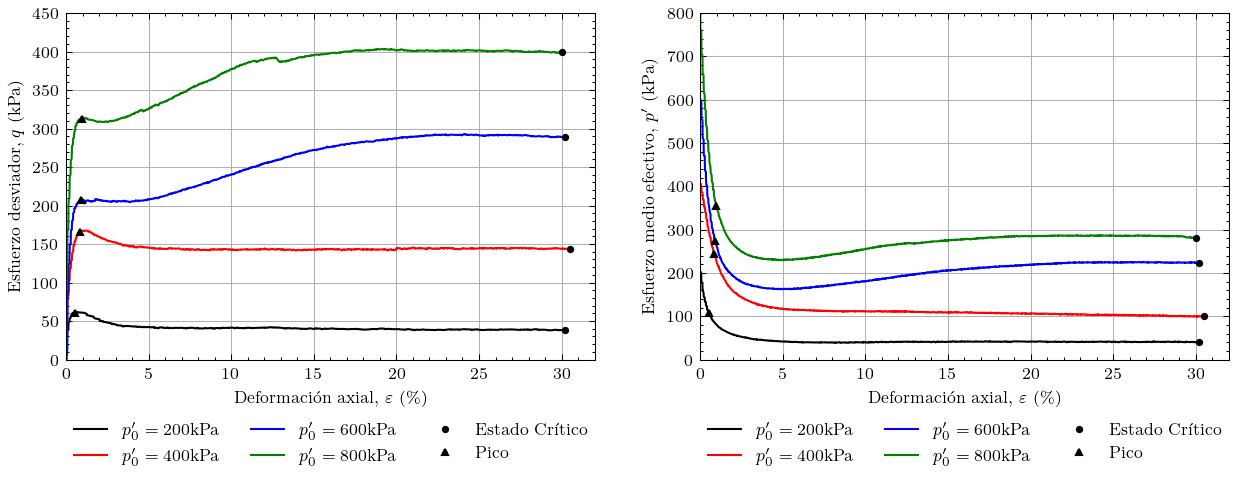

In [97]:
# Ploteamos los resultados obtenidos
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

for i in range(N_samples):
    
    ax[0].plot(
        Samples[i]["e(axis)(%)"], 
        Samples[i]["q (kPa)"], 
        "-", 
        label = labels_samples[i]
        )
    
    ax[1].plot(
        Samples[i]["e(axis)(%)"],
        Samples[i]["p\' (kPa)"],
        "-", 
        label = labels_samples[i]
        )

# Obtenemos la localización del estado crítico
ax[0].plot(
    max_def, critical_q[1:], 
    "o", 
    color = "black", 
    markersize = 2.5,
    label = "Estado Crítico"
    )

# Calculamos el exceso de presión de poros asociado
excess_pp = np.array(
    [Samples[i]["u (kPa)"].iloc[-1] for i in range(N_samples)]
)

ax[1].plot(
    max_def, 
    critical_p[1:],
    "o",
    color = "black",
    markersize = 2.5,
    label = "Estado Crítico"
)

# Ploteamos el pico
ax[0].plot(
    peak_def,
    peak_q, 
    "^", 
    color = "black", 
    markersize = 2.5,
    label = "Pico"
    )

ax[1].plot(
    peak_def,
    peak_p, 
    "^",
    color = "black",
    markersize = 2.5,
    label = "Pico"
)

ax[0].grid()
ax[0].set_xlim(0, 32)
ax[0].set_ylim(0, 450)
ax[0].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[0].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[0].set_ylabel("Esfuerzo desviador, $q$ (kPa)")

ax[1].grid()
ax[1].set_xlim(0, 32)
ax[1].set_ylim(0, 800)
ax[1].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[1].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[1].set_ylabel(r"Esfuerzo medio efectivo, $p'$ (kPa)")
plt.show()

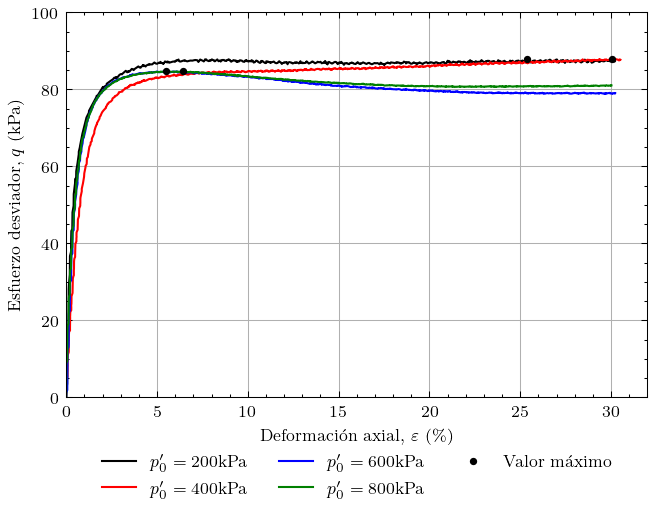

In [146]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4*5/6))

for i in range(N_samples):
    
    Samples[i]["Ru"] =  Samples[i]["PWP Excess (kPa)"] * 100 / Samples[i]["p\' (kPa)"].iloc[0]
    
    ax.plot(
        Samples[i]["e(axis)(%)"], 
        Samples[i]["Ru"], 
        "-", 
        label = labels_samples[i]
        )
    
   
Ru_dataframe = [Ru_df[Ru_df["Ru"] == Ru_df["Ru"].max()] for Ru_df in Samples]

Ru_def = np.array(
    [Ru_dataframe[i]["e(axis)(%)"] for i in range(N_samples)]
    )

Ru_Ru = np.array(
    [Ru_dataframe[i]["Ru"] for i in range(N_samples)]
    )

ax.plot(
    Ru_def, Ru_Ru, 
    "o", 
    color = "black", 
    markersize = 2.5,
    label = "Valor máximo"
    )


ax.grid()
ax.set_xlim(0, 32)
ax.set_ylim(0, 100)

ax.set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax.set_ylabel("Esfuerzo desviador, $q$ (kPa)")
ax.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.3), ncol = 3)
fig.savefig("Ru result.svg", format="svg")
plt.show()

# P10. Obtención de resistencia no drenada normalizada en el estado crítico

In [209]:
sr_result = pd.DataFrame(
    {
        "Presión de confinamiento": [Samples[i]["p\' (kPa)"].iloc[0] for i in range(N_samples)],
        "Parámetro de estado": psi
    }
)

sr_result["Resistencia no drenada normalizada"] = (M_cs/2) * (np.e ** (sr_result["Parámetro de estado"]/lambda_e))
sr_result

,Presión de confinamiento,Parámetro de estado,Resistencia no drenada normalizada
0,202.757028,0.051176,0.139084
1,403.954831,0.045296,0.167055
2,600.548500,0.033021,0.244897
3,799.373763,0.032198,0.251256


## P10.1 Ángulo de fricción mobilizado en el cuasi estado critico

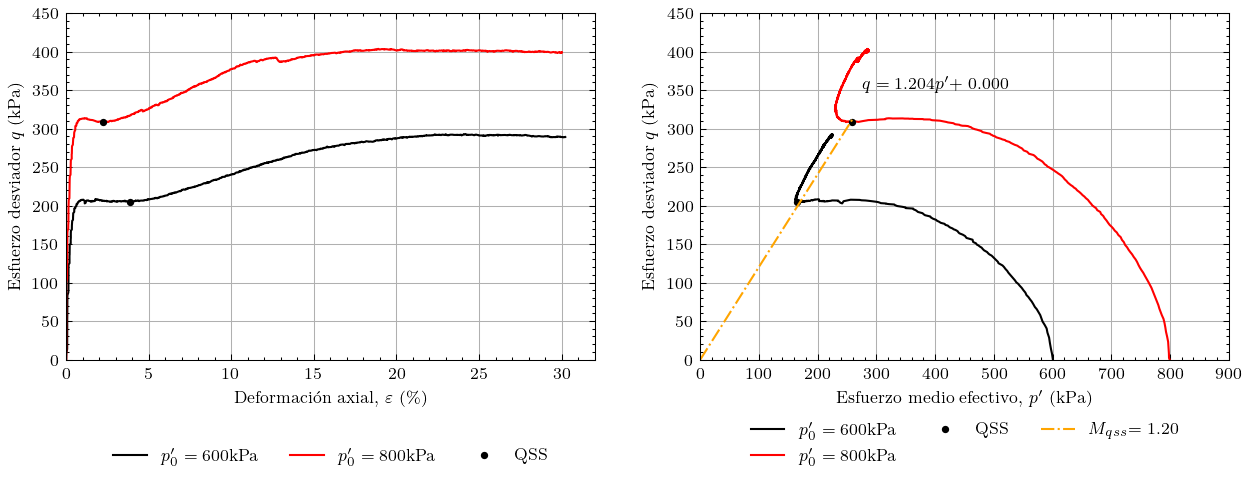

In [205]:
peak_dataframe = [
    Samples_3percent[0].iloc[54],
    Samples_3percent[1].iloc[130],
    Samples_3percent[2].iloc[105],
    Samples_3percent[3].iloc[160],
]

Samples_qss = [Samples[i].loc[(Samples[i]["e(axis)(%)"] < 5) & (Samples[i]["e(axis)(%)"] > 2)] for i in range(N_samples)]
qss_points = [df[df["q (kPa)"] == df["q (kPa)"].min()] for df in Samples_qss]

p_qss = np.array([[0], qss_points[2]["p\' (kPa)"], qss_points[3]["p\' (kPa)"]]).flatten()
q_qss = np.array([[0], qss_points[2]["q (kPa)"], qss_points[3]["q (kPa)"]]).flatten()

# Regresión Linea con intercepción 0

def linear_function(x, m):
    return m * x

params, covariance = curve_fit(linear_function, p_qss , q_qss)
slope = params[0]

M_qss = slope
phi_qss = np.arcsin((3 * M_qss)/ (6 + M_qss)) * 180 / np.pi

# Ploteamos los resultados obtenidos
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

for i in range(N_samples):
    if i == 0 or i == 1:
        pass
    else:
        ax[0].plot(Samples[i]["e(axis)(%)"], Samples[i]["q (kPa)"], "-", label = labels_samples[i])
        ax[1].plot(Samples[i]["p\' (kPa)"], Samples[i]["q (kPa)"], "-", label = labels_samples[i])

ax[0].plot(qss_points[2]["e(axis)(%)"], qss_points[2]["q (kPa)"], "o", color = "black", markersize = 2.5)
ax[0].plot(qss_points[3]["e(axis)(%)"], qss_points[3]["q (kPa)"], "o", color = "black", markersize = 2.5, label = "QSS")

ax[1].plot(qss_points[2]["p\' (kPa)"], qss_points[2]["q (kPa)"], "o", color = "black", markersize = 2.5)
ax[1].plot(qss_points[3]["p\' (kPa)"], qss_points[3]["q (kPa)"], "o", color = "black", markersize = 2.5, label = "QSS")

# ax[1].plot(critical_p, critical_q, "o", color = "black", markersize = 2.5)
ax[1].plot(p_qss, slope * p_qss, "-.", color='orange', 
        label='$M_{qss}$'+ "$ = {:.2f}$".format(round(M_qss, 2)))

ax[0].grid()
ax[0].set_xlim(0, 32)
ax[0].set_ylim(0, 450)
ax[0].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[0].set_xlabel(r"Deformación axial, $\varepsilon$ (\%)")
ax[0].set_ylabel("Esfuerzo desviador $q$ (kPa)")

ax[1].grid()
ax[1].set_xlim(0, 900)
ax[1].set_ylim(0, 450)
ax[1].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)
ax[1].set_xlabel("Esfuerzo medio efectivo, $p'$ (kPa)")
ax[1].set_ylabel("Esfuerzo desviador $q$ (kPa)")
ax[1].text(275, 350, "$q = {:.3f} p'$".format(round(slope,3)) + "+ ${:.3f}$".format(round(intercept,3)))

plt.savefig('p-q diagram_qss.svg', format='svg')

plt.show()



In [211]:
qss_sr_result = pd.DataFrame(
    {
        "Presión de confinamiento": [Samples[i+2]["p\' (kPa)"].iloc[0] for i in range(N_samples-2)],
        "Esfuerzo Desviador": q_qss[1:]
    }
)

qss_sr_result["Resistencia no drenada normalizada"] = (qss_sr_result["Esfuerzo Desviador"] / 2) * np.cos(np.radians(phi_qss)) / qss_sr_result["Presión de confinamiento"]

qss_sr_result

,Presión de confinamiento,Esfuerzo Desviador,Resistencia no drenada normalizada
0,600.548500,204.346044,0.147198
1,799.373763,308.381016,0.166887


### ~P.1.2. Resistencia al corte en el pico

In [212]:
sigma = [[Samples[i]["s3_eff (kPa)"][0] - peak_dataframe[i]["PWP Excess (kPa)"],
          Samples[i]["s3_eff (kPa)"][0] + peak_dataframe[i]["q (kPa)"] - peak_dataframe[i]["PWP Excess (kPa)"]] for i in range(N_samples)]
sigma

[[87.46857533333332, 148.40620366666664],
 [188.45727200000005, 354.2291103333334],
 [202.6936, 409.831156],
 [252.57612500000005, 565.298125]]

In [213]:
sigma3s = np.array([sample_sigma[0] for sample_sigma in sigma])
sigma1s = np.array([sample_sigma[1] for sample_sigma in sigma]) 
radii = 0.5 * (sigma1s - sigma3s)
centers = 0.5 * (sigma1s + sigma3s)

def objective_func(x, sigma1_effs, sigma3_effs):
    """
    Returns the squared sum of residuals for the array x
    where x[0] = tan phi and x[1] = c'
    sigma1_effs is an array with the major principal effective 
    stresses for each Mohr circle
    sigma3_effs is an array with the minor principal effective
    stresses for each Mohr circle
    """
    epsilons = np.zeros(sigma1_effs.__len__())
    for i, (sigma1, sigma3) in enumerate(zip(
        sigma1_effs, sigma3_effs)):
        epsilons[i] = (
            np.abs(x[0] * 0.5 * (sigma1 + sigma3) + x[1]) / \
            np.sqrt(x[0] ** 2 + 1) - (0.5 * (sigma1 - sigma3))) ** 2
        
    return epsilons.sum()

minimised_params = minimize(
    objective_func, # A function of one of more variables
    x0=np.array([np.tan(np.radians(10)), 10]), # Initial guess
    method='SLSQP', # Method used for the minimisation
    args=(sigma1s, sigma3s), # Function arguments
    bounds=(
        (np.tan(np.radians(5)), np.tan(np.radians(50))),
        (0, None)) # Bounds between which the parameters may vary
)

effective_friction_angle = round(
    np.rad2deg(np.arctan(minimised_params.x[0])), 1)
effective_cohesion = round(minimised_params.x[1], 1)
print(effective_friction_angle, effective_cohesion)


20.4 0.0


c:\Users\cesar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


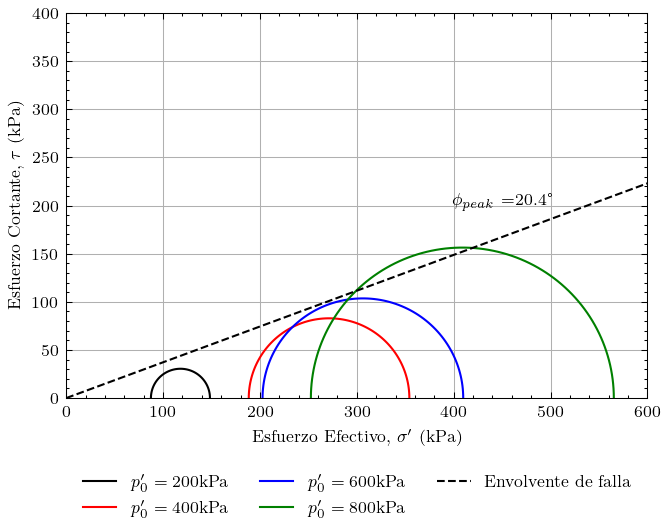

In [214]:
# Crear plot de los circulos de Mohr Coulomb
fig, ax = plt.subplots(1, 1, figsize = (5, 400/60/2))
for i in range(N_samples):
    
    # Crear los circulos
    x1, x2 = sigma[i]
    num_points = 100
    theta = np.linspace(0, np.pi, num_points)
    x = (x1 + x2) / 2 + (x2 - x1) / 2 * np.cos(theta)
    y = (x2 - x1) / 2 * np.sin(theta)

    # Plotear los resultados
    ax.plot(x, y, "-" , label = labels_samples[i])

# Añadimos un label de envolvente de falla
ax.plot([0, 600], 
        [effective_cohesion, effective_cohesion + 600 * np.tan(np.radians(effective_friction_angle))],
        "--",
        label = "Envolvente de falla",
        color = "black")

# Mostramos el ángulo de fricción obtenido para el estado critico
ax.text(450, 200, r"$\phi_{peak}=$" + str(effective_friction_angle) + "°", ha = "center") 

ax.set_xlabel("Esfuerzo Efectivo, $\sigma'$ (kPa)")
ax.set_ylabel(r"Esfuerzo Cortante, $\tau$ (kPa)")
ax.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.35), ncol = 3)

ax.set_xlim(0, 600)
ax.set_ylim(0, 400)
ax.grid()
plt.savefig('peak mohr circle.svg', format='svg')
plt.show()